In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from gccNMF.gccNMFFunctions import *
from gccNMF.gccNMFPlotting import *
from scipy.io import wavfile
from IPython import display
from spectre import *
from SpikeSep import triggers, multi_stft, remove_trigger, estimate_fw_mapping, step_bf, break_small
import IPython.display as ipd 
import mir_eval
from scipy.signal import butter, lfilter, freqz

In [2]:
def low_pass(x, l=50):
    r = np.zeros_like(x)
    for i in range(len(x) - l):
        r[i] = np.mean(x[i:i+l])
    return r

# low pass 
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [362]:
pos = [3,9]
sample = 'A'
base_dir = '/Data/Dropbox/Shared ISCAS2017Submissions/RecordingsDungeon/'
[sampleRate, x_mix] = wavfile.read(base_dir + 'dungeon_concurrent_{}_{}_{}_1.wav'.format(pos[0], pos[1], sample))

TR = 10000 if sample in ['A', 'C'] and pos == [9, 7] else 18000
trigger_index = np.where(x_mix > TR)[0][0]
x_mix = x_mix[trigger_index + int(sampleRate / 32):].astype('float32')


print(x_mix.shape)

# Preprocessing params
windowSize = 1024
fftSize = windowSize
hopSize = 128
windowFunction = hanning

# TDOA params
numTDOAs = 128

# NMF params
dictionarySize = 128
numIterations = 100
sparsityAlpha = 0

# Input params    
mixtureFileNamePrefix = '../data/dev1_female3_liverec_130ms_1m'
microphoneSeparationInMetres = 0.5
numSources = 3

(1414207, 4)


In [363]:
lp = 11000
stereo_signal = np.array([butter_lowpass_filter(x_mix[:, 0], lp, sampleRate), 
                          butter_lowpass_filter(x_mix[:, 1],  lp, sampleRate)]).T 
complexMixtureSpectrogram = computeComplexMixtureSpectrogram(stereo_signal.T, windowSize, hopSize, windowFunction ) 
numChannels, numFrequencies, numTime = complexMixtureSpectrogram.shape
frequenciesInHz = getFrequenciesInHz(sampleRate, numFrequencies)
frequenciesInkHz = frequenciesInHz / 1000.0

In [364]:
spectralCoherenceV = complexMixtureSpectrogram[0] * complexMixtureSpectrogram[1].conj() \
                     / abs(complexMixtureSpectrogram[0]) / abs(complexMixtureSpectrogram[1])
angularSpectrogram = getAngularSpectrogram( spectralCoherenceV, frequenciesInHz,
                                            microphoneSeparationInMetres, numTDOAs )
angularSpectrogram = np.nan_to_num(angularSpectrogram)
meanAngularSpectrum = mean(angularSpectrogram, axis=-1) 
targetTDOAIndexes = estimateTargetTDOAIndexesFromAngularSpectrum( meanAngularSpectrum,
                                                                  microphoneSeparationInMetres,
                                                                  numTDOAs, numSources)


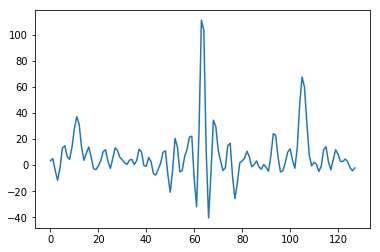

In [365]:
plt.plot(meanAngularSpectrum)

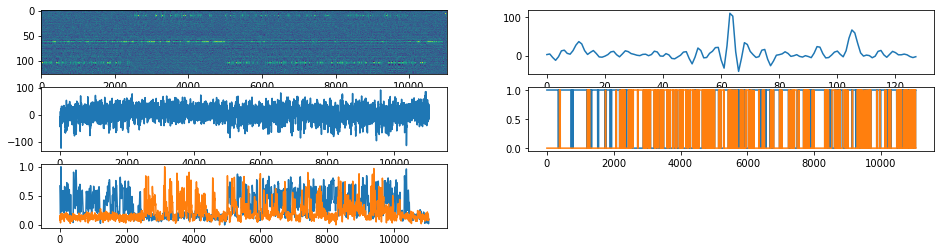

In [380]:
TH = 0.9
LP = 10
windowSize = 2048
hopSize = 512
BW_ms = 200
BW = int(np.ceil(BW_ms / 1000.0 * sampleRate / hopSize))

one = np.zeros((angularSpectrogram.shape[1],))
two = np.zeros((angularSpectrogram.shape[1],))
both = np.zeros((angularSpectrogram.shape[1],))
a, b, c = triggers(sample, sampleRate, hopSize)

one[a] = 100
two[b] = 100
both[c[0]] = 100
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(3,2,1)
ax.imshow(angularSpectrogram, aspect="auto")
# plt.plot(one, 'r')
# plt.plot(two, 'y')
# plt.plot(both, 'b')
ax = fig.add_subplot(3,2,2)
ax.plot(meanAngularSpectrum)
# print(targetTDOAIndexes)
# plt.figure()
# plt.plot()
ax = fig.add_subplot(3,2,3)
ax.plot(angularSpectrogram[116, :])

B = low_pass(angularSpectrogram[targetTDOAIndexes[0], :], l=LP)
A = low_pass(angularSpectrogram[targetTDOAIndexes[-1], :], l=LP)
A -= np.mean(A)
B -= np.mean(B)
A -= np.min(A)
B -= np.min(B)
A /= np.max(A)
B /= np.max(B)



vad1 = np.float32(A * TH > B)
vad2 = np.float32(B * TH > A)

ax = fig.add_subplot(3,2,4)
ax.plot(vad1)
ax.plot(vad2)

ax = fig.add_subplot(3,2,5)
ax.plot(A)
ax.plot(B)


In [381]:
prefix_filenames = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/dungeon_concurrent_'

filename_id = '%d_%d_%s' %(pos[0], pos[1], sample)
filename_whisper1 = prefix_filenames + filename_id + '_1.wav'
filename_whisper3 = prefix_filenames + filename_id + '_3.wav'
filename_groundtruth1 = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/edited%s1_T.wav' %sample
filename_groundtruth8 = '/Data/Dropbox/spike_separation_joy/recordings_dungeon/edited%s8_T.wav' %sample
fs, whisper1 = wavfile.read(filename_whisper1)
fs, whisper3 = wavfile.read(filename_whisper3)
# plt.plot(whisper1[:115000, 0])
# ipd.display(ipd.Audio(whisper1[:200000, 0], rate=fs))
TR = 10000 if sample in ['A', 'C'] and pos == [9, 7] else 18000
# TR = 10000
trigger_index = np.where(whisper1>TR)[0][0]
# trigger_index = np.where(whisper1[:,0]>TR)[0][0]
# print trigger_index
# trigger_index = 115000
whisper1 = whisper1[trigger_index + int(fs / 32):].astype('float32')
whisper3 = whisper3[trigger_index + int(fs / 32):].astype('float32')

# make the same length
shortest_size = np.amin((whisper1.shape[0], whisper3.shape[0]))
whisper1_shortened = whisper1[:shortest_size,:]
whisper3_shortened = whisper3[:shortest_size,:]
whisper = np.concatenate((whisper1_shortened,whisper3_shortened),1)

# gt
fs, groundtruth1 = wavfile.read(filename_groundtruth1)
groundtruth1 = remove_trigger(groundtruth1)
fs, groundtruth8 = wavfile.read(filename_groundtruth8)
groundtruth8 = remove_trigger(groundtruth8)

# stfts & VADs
m2 = stft(groundtruth8, windowSize, hopSize, window=np.hanning).T
m1 = stft(groundtruth1, windowSize, hopSize, window=np.hanning).T
m1_sum = np.sum(np.log(m1 + 1), axis=-1)
m2_sum = np.sum(np.log(m2 + 1), axis=-1)
VAD1 = np.array(0.8 * m1_sum > m2_sum)
VAD2 = np.array(0.8 * m2_sum > m1_sum)

x_spec = np.transpose(multi_stft(whisper.T, windowSize, hopSize), (0, 2, 1))

In [382]:
print(len(vad1))
print(len(VAD1))

R = int(np.floor(len(vad1) / len(VAD1)))
print(R)
vad1 = vad1[::R]
vad2 = vad2[::R]

min_len = min([len(vad1), len(VAD1)])
vad1 = vad1[:min_len]
vad2 = vad2[:min_len]
VAD1 = VAD1[:min_len]
VAD2 = VAD2[:min_len]


11041
2537
4


CORR: 0.4523 || 0.4725
Estimated JIT 8.0 || Theoretical JIT = 2
AFTER: 0.4824 || 0.5074


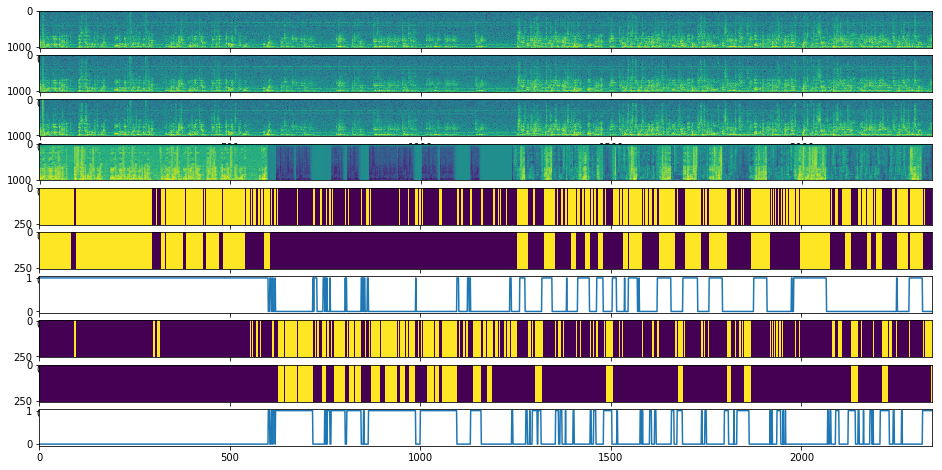

In [383]:
JIT = 2
# solid_vad1 = np.tile(np.expand_dims(vad1, -1), (1, int(frame_len / 2 + 1)))
# solid_vad2 = np.tile(np.expand_dims(vad2, -1), (1, int(frame_len / 2 + 1)))

if np.corrcoef(vad1, VAD1)[0,1] < 0:
    _tmp = vad1[:]
    vad1 = vad2[:]
    vad2 = _tmp[:]
    
solid_vad1 = np.tile(np.expand_dims(vad1, -1), (1, int(hopSize/ 2 + 1)))
solid_vad2 = np.tile(np.expand_dims(vad2, -1), (1, int(hopSize / 2 + 1)))

solid_vad11 = np.tile(np.expand_dims(break_small(vad1, BW), -1), (1, int(hopSize / 2 + 1)))
solid_vad22 = np.tile(np.expand_dims(break_small(vad2, BW), -1), (1, int(hopSize / 2 + 1)))



print("CORR: {:.4} || {:.4}".format(np.corrcoef(vad1, VAD1)[0,1], np.corrcoef(vad2, VAD2)[0,1]))
mc1 = np.argmax(np.correlate(vad1, VAD1, "full")) - len(VAD1)
mc2 = np.argmax(np.correlate(vad2, VAD2, "full")) - len(VAD2)
print("Estimated JIT {} || Theoretical JIT = {}".format(np.mean([mc1, mc2]), JIT))
# JIT = int(np.mean([mc1, mc2])
print("AFTER: {:.4} || {:.4}".format(np.corrcoef(vad1[JIT:], VAD1[:-JIT])[0,1], np.corrcoef(vad2[JIT:], VAD2[:-JIT])[0,1]))
# JIT = 140
# print solid_vad1.shape
lim0 = int(sampleRate * 0 / hopSize)
lim1 = int(sampleRate * 50 / hopSize)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(10,1,1)
ax.imshow(np.log(np.abs(x_spec[0][lim0:lim1, ::-1]).T + 1), aspect="auto")
ax = fig.add_subplot(10,1,2)
ax.imshow(np.log(np.abs(x_spec[1][lim0:lim1, ::-1]).T + 1), aspect="auto")
ax = fig.add_subplot(10,1,3)
ax.imshow(np.log(np.abs(x_spec[2][lim0:lim1, ::-1]).T + 1), aspect="auto")
ax = fig.add_subplot(10,1,4)
pos1 = np.abs(m1[lim0:lim1, ::-1]) 
neg1 = np.abs(m2[lim0:lim1, ::-1]) 
ax.imshow((np.log(pos1 + 1) - np.log(neg1 + 1)).T , aspect="auto")
ax = fig.add_subplot(10,1,5)
ax.set_xlim([0, lim1 - lim0])
ax.imshow(solid_vad1[lim0 + JIT:lim1 + JIT].T, aspect="auto")
ax = fig.add_subplot(10,1,6)
ax.set_xlim([0, lim1 - lim0])
ax.imshow(solid_vad11[lim0 + JIT:lim1 + JIT].T, aspect="auto")
ax = fig.add_subplot(10,1,7)
ax.set_xlim([0, lim1 - lim0])
ax.plot(VAD1[lim0:lim1].T)
ax = fig.add_subplot(10,1,8)
ax.set_xlim([0, lim1 - lim0])
ax.imshow(solid_vad2[lim0 + JIT:lim1 + JIT].T, aspect="auto")
ax = fig.add_subplot(10,1,9)
ax.set_xlim([0, lim1 - lim0])
ax.imshow(solid_vad22[lim0 + JIT:lim1 + JIT].T, aspect="auto")
ax = fig.add_subplot(10,1,10)
ax.set_xlim([0, lim1 - lim0])
ax.plot(VAD2[lim0:lim1].T)

In [384]:
ch0 = np.array([0,1,2,5,6])
ch1 = np.array([0,1,2,5,6])

_, _, vad_slice = triggers(sample, sampleRate, hopSize, 0)
_, _, spec_slice = triggers(sample, sampleRate, hopSize)
x_spec = x_spec[:, :len(vad1), :]
recons = []

for vad, ch in zip([vad1, vad2], [ch0, ch1]):
    # vad = vad[vad_slice]
    vad = np.expand_dims(np.expand_dims(break_small(vad, BW), 0), -1)
    # vad = np.concatenate([vad[:, vad_slice[0]], vad[:, vad_slice[1]]], axis=1)
    xx = []
    for v_sl, x_sl in zip(vad_slice, spec_slice):
#         plt.figure()
#         plt.imshow(vad[0, v_sl], aspect='auto')
        xx += [x_spec[ch, x_sl] * vad[:, v_sl]]
    # x_spec_a = x_spec[:, spec_slice]
    # x_spec_a = x_spec_a[:, :vad.shape[1]]
    ll1 = estimate_fw_mapping(np.concatenate(xx, axis=1))
    x_spec_b = x_spec[ch].T
    w = step_bf(x_spec_b, ll1)
    recons.append(np.einsum('ab,acb->ca', np.conj(w), x_spec_b))

recons[0] = istft(recons[0].T, hop_length=hopSize, window=np.hanning)
recons[1] = istft(recons[1].T, hop_length=hopSize, window=np.hanning)

5525 || 5483


SIR [13.35496906 15.14020598]
[-4.75285011 -1.00445758]


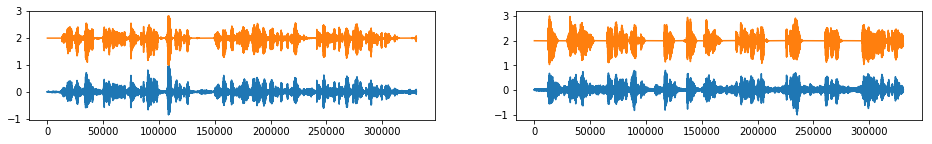

In [385]:
# correct for filter length
init1 = 0
init0 = int(26 * sampleRate) if sample == 'A' else int(13 * sampleRate)
init2 = int(40 * sampleRate) if sample == 'A' else int(26 * sampleRate)
recons0 = recons[0][init0:init2]
recons1 = recons[1][init0:init2]
groundtruth11 = groundtruth1[init0:]
groundtruth88 = groundtruth8[init0:]

end = 100000

pp = np.correlate(recons1[init1:init1 + end], groundtruth88[init1:init1 + end], 'full')
j1 = np.argmax(pp) - end

pp = np.correlate(recons0[init1:init1 + end], groundtruth11[init1:init1 + end], 'full')
j0 = np.argmax(pp) - end

print("{} || {}".format(j0, j1))

if j0 > 0:
    recons0 = recons0[j0:]
else:
    groundtruth11 = groundtruth11[abs(j0):]
        
if j1 > 0:
    recons1 = recons1[j1:]
else:
    groundtruth88 = groundtruth88[abs(j1):]
min_len = np.min([len(recons0), len(recons1), len(groundtruth11), len(groundtruth88)])
recons0 = recons0[:min_len]
recons1 = recons1[:min_len]
groundtruth11 = groundtruth11[:min_len]
groundtruth88 = groundtruth88[:min_len]

fig = plt.figure(figsize=(16,2))
ax = fig.add_subplot(1,2,1)
ax.plot(recons0 / np.max(abs(recons0)))
ax.plot(groundtruth11 / np.max(np.abs(groundtruth11)) + 2)
# ax.plot(whisper[:, 0] / np.max(np.abs(whisper[:, 0])))
ax = fig.add_subplot(1,2,2)
ax.plot(recons1 / np.max(abs(recons1)))
ax.plot(groundtruth88 / np.max(np.abs(groundtruth88)) + 2)

ipd.display(ipd.Audio(recons0[:200000], rate=sampleRate))
ipd.display(ipd.Audio(recons1[:200000], rate=sampleRate))
ipd.display(ipd.Audio(groundtruth11[:200000], rate=sampleRate))
ipd.display(ipd.Audio(groundtruth88[:200000], rate=sampleRate))
sdr, sir, sar, perm = mir_eval.separation.bss_eval_sources(np.array([groundtruth11, groundtruth88]), np.array([recons0, recons1]))
print("SIR {}".format(sir))
print(sdr)